In [1]:
from parsing import *
from database_functions import *
from ml_functions import *

In [ ]:
#patients, appointments, weather = parsing(data_raw_fname = '/Users/jenniferpolson/Documents/School/2017-F/BE 223A/Final Project/Functionalize/be223a_dataset_full.csv', 
#             encoding = "ISO-8859-1", 
#             dtformat = '%Y-%m-%d %H:%M:%S', 
#             exam_id = 'examId', patientdeid = 'Patient ID', age = 'AgeatExam', gender = 'Gender'))

In [2]:
data_raw_fname = '/Users/jenniferpolson/Documents/School/2017-F/BE 223A/Midterm Project/be223a_dataset.csv'
encoding=None
dtformat='%m/%d/%y %H:%M'
patients, appointments, weather = parsing(data_raw_fname, encoding, dtformat, 
                                          exam_id = 'Exam ID', pt_id = 'Patient ID', age = 'Age', gender = 'Gender')

Reading /Users/jenniferpolson/Documents/School/2017-F/BE 223A/Midterm Project/be223a_dataset.csv
Processed in 3.362 seconds.


In [3]:
#Input Parameters
dbname = "223ADB3.db"
patient_key = "Patient_ID"
appointment_key = "Exam_ID"
weather_key = "Dayofyear"

In [4]:
connection = new_connection(dbname)

In [5]:
#Generating SQL Strings
patients_string=generate_string("patients", patients , patient_key, [])
appointments_string=generate_string("appointments", appointments, appointment_key, [patient_key, weather_key])
weather_string=generate_string("weather", weather, "Dayofyear", [])

In [6]:
# Creating tables

create_table(dbname, patients_string)
create_table(dbname, appointments_string)
create_table(dbname, weather_string)

In [7]:
# Creating foreign keys

fkey1=foreignkey("appointments", patient_key, "patients", patient_key)
fkey2=foreignkey("appointments", weather_key, "weather", weather_key)


# Creating foreign key columns
#create_key(dbname, fkey1)
#create_key(dbname, fkey2)

In [8]:
# Push dataframe into database

push_dataframe(patients,dbname, "patients")
push_dataframe(appointments, dbname, "appointments")
push_dataframe(weather,dbname, "weather")

In [9]:
#other function: pull from DB, rearrange to data output
patients = query_data(dbname, "SELECT * from patients") 
appointments = query_data(dbname, "SELECT * from appointments")
weather = query_data(dbname, "SELECT * from weather")

In [10]:
df = create_df(appointments, patients, weather, 'Patient_ID', 'Dayofyear').drop('index', axis = 1)

Preprocessing Completed in 110.158 seconds.
GridSearch was not run. Default parameters selected:
- Class Weight: balanced
- Criterion: entropy
- Maximum Features: 0.8
- Number of Estimators: 50
Running the Random Forest Classifier.
Feature ranking:


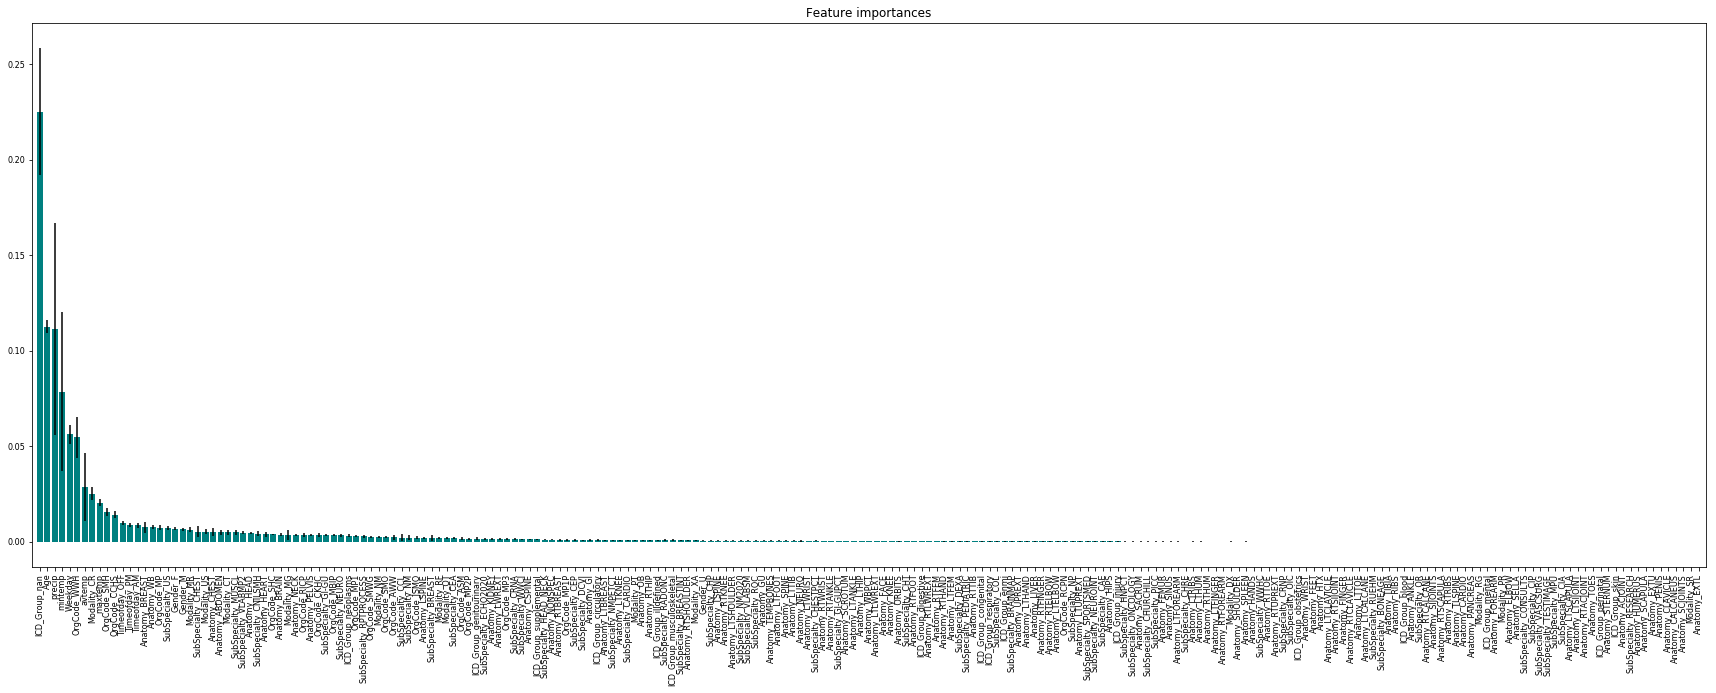

Random Forest Classifier Model run in 106.879 seconds.


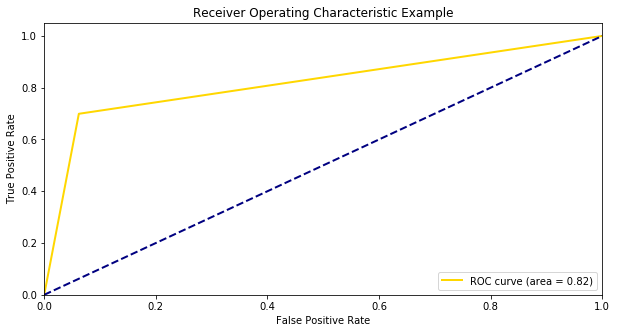

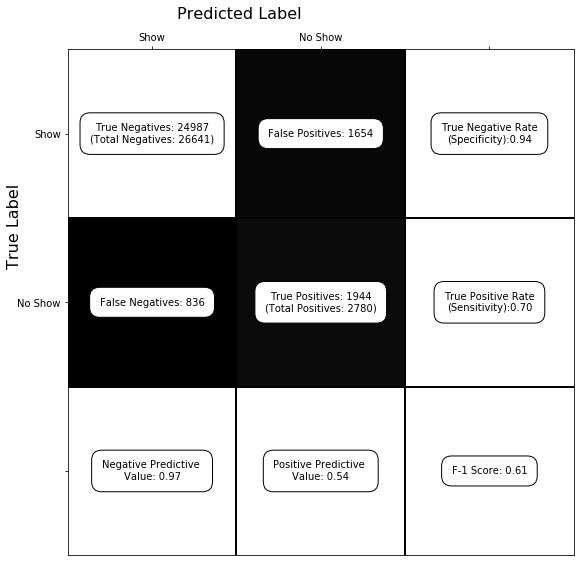

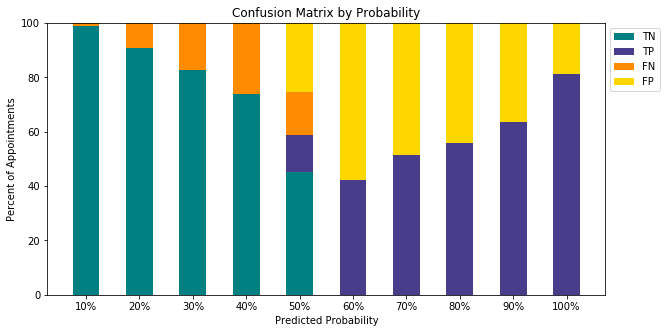

Model Analysis processed in 0.454 seconds.
Pipeline completed in 218.335 seconds.


In [11]:
#run ML
results, test, prob, groups, evalstats, sort_features = run_model(df, k = 5000, tune_parameters = False)

In [12]:
#create new table
results_string = generate_string ('results', results, 'Patient_ID', []) #patient ID
create_table(dbname, results_string)

#push the data to the table
push_dataframe(results,dbname, 'results')

In [ ]:
#circular - to make sure it actually worked
#results = query_data(dbname, "SELECT * from results") 